In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import joblib as jb
from glob import glob
from lightgbm import LGBMRegressor
import colorsys
from preprocessing import *

# 1.0 - Read Data

In [6]:
path_bat = '/home/vinicius/Área de Trabalho/Faculdade/TCC/data/DADOS_TCC_BIANCA/02.Dados_Processados/02.XYZ/BATIMETRIA_PROCESSADA_BABITONGA_2018_DHN_WGS84_UTM22S.xyz'

In [7]:
rhos_list = [e for e in glob('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/*.tif') if 'rhos' in str(e)]

In [8]:
rhos_list

['../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_740.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_704.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_665.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_492.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_560.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_783.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_833.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_443.tif']

In [12]:
bands_name = ['b6', 'b5', 'b4', 'b2', 'b3','b7', 'b8', 'b1']

In [10]:
# create dictionary with images array referenced by band name 
tiff_dict = dict()
for i, path in enumerate(rhos_list):
    tiff_dict[f'{bands_name[i]}'] = tifffile.TiffFile(path).asarray()

In [14]:
#jb.dump(tiff_dict, 'output_data/tiff_dict.pkl.z') # save 
tiff_dict = jb.load('output_data/tiff_dict.pkl.z') # load dict with tiffs arrays for each band

In [15]:
# Read bathymetry data
df = pd.read_csv(path_bat, sep=' ', header=None)
df.columns = ['x', 'y', 'z']
df.head(2)

,x,y,z
0,720507.82,7089857.17,1.96
1,720507.95,7089857.15,1.98


# 2.0 - Process Data

In [ ]:
# NDWI for B3 and B8 - Water filter 
ndwib3b8 = ndwi(tiff_dict['b3'], tiff_dict['b8'])

In [18]:
#jb.dump(ndwib3b8, 'output_data/ndwib3b8.pkl.z') # save ndwi data
ndwib3b8 = jb.load('output_data/ndwib3b8.pkl.z') # load ndwi data

In [20]:
# Apply threshold to water-ground
wf_th = 0.3
ndwib3b8 = (ndwib3b8[:,:] > wf_th)
ndwib3b8 # boolean image to save processing

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True]])

In [16]:
water_filter = ndwib3b8.astype(np.uint8) * 255 # water filter [0, 255] image

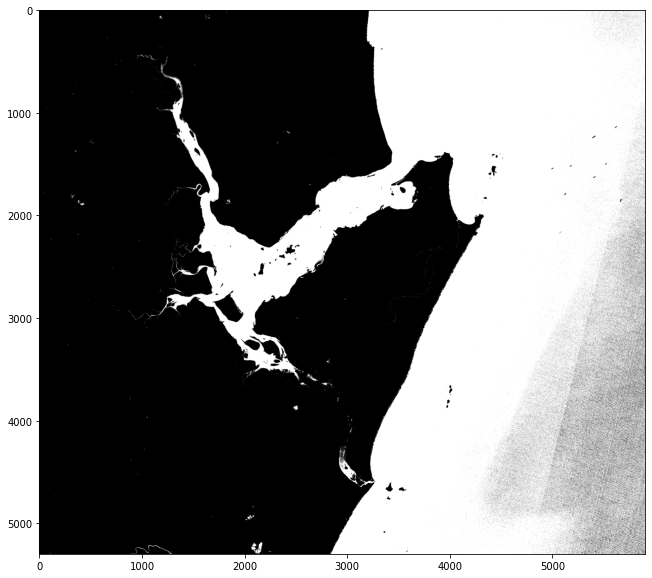

In [11]:
plt.figure(figsize=(12,10))
plt.imshow(water_filter, "gray")

In [21]:
# Create BGR image with blue, green and red bands
bgr_image = np.dstack((tiff_dict['b2'],tiff_dict['b3'],tiff_dict['b4']))
bgr_image = bgr_image + 0.1
bgr_image = bgr_image.clip(0,1)

In [22]:
bgr_image = (bgr_image*255.99).astype(np.uint8)

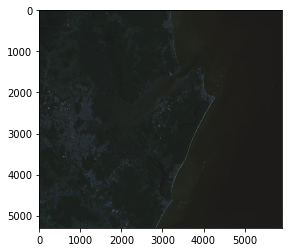

In [23]:
plt.imshow(bgr_image)

In [24]:
# B7 fix rate - did it because the shape of b7 is different (but the info too?)
b7fix = tiff_dict['b7'].shape[0]/float(tiff_dict['b1'].shape[0])
b7fix

0.6647791619479049

In [25]:
from tqdm.notebook import tqdm
# Create an array containing the position (X,Y) and all the bands reflectances 
aux = list()
for i in tqdm(range(bgr_image.shape[0])):
    for j in range(bgr_image.shape[1]):
        if ndwib3b8[i][j]:
            aux.append(np.array([j,i, tiff_dict['b6'][i][j], tiff_dict['b5'][i][j], tiff_dict['b4'][i][j], 
                                 tiff_dict['b2'][i][j], tiff_dict['b3'][i][j], tiff_dict['b7'][int(np.clip(i*b7fix,0, tiff_dict['b7'].shape[0]))][j],tiff_dict['b8'][i][j], tiff_dict['b1'][i][j]]))

In [29]:
# Save all reflectances data array
hf = h5py.File('output_data/array_allpixels_allbands.h5', 'w')
hf.create_dataset('dataset_1', data=aux)
hf.close()

In [33]:
del aux #clean memory

In [34]:
import pandas as pd

In [32]:
columns = ['px', 'py'] + bands_name

In [57]:
# Read all reflectances data array
hf = h5py.File('output_data/array_allpixels_allbands.h5', 'r')
aux = np.array(hf.get('dataset_1'))
hf.close()

In [61]:
# Create dataframe with reflectances array
df_all = pd.DataFrame(aux)
df_all.columns = columns

# 3.0 - Predict

In [66]:
# Load model
lgbm = jb.load('models/lgbm_baseline.pkl.z')

In [67]:
z = lgbm.predict(df_all.drop(["px","py"],axis=1))

In [69]:
# Save predictions data
hf = h5py.File('output_data/predictions_baseline.h5', 'w')
hf.create_dataset('dataset_pred', data=z)
hf.close()

In [76]:
# Add predictions to dataframe column
df_all['z'] = z

In [77]:
# Fill output image with colors range
output = bgr_image.copy()
for i, row in tqdm(enumerate(df_all.itertuples())):
    x = int(row[1])
    y = int(row[2])
    z = row[11]
    output[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(z/40, 0.5, 1))]

# 4.0 - Save Output

In [80]:
import cv2
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)

In [96]:
cv2.imwrite("photos/predict_baseline_result.png", output)

True

In [127]:
output = cv2.imread('photos/predict_baseline_result.png')

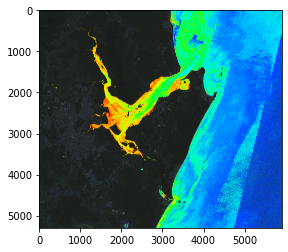

In [133]:
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))